# DDPG Agent

In [1]:
"""
Deep Deterministic Policy Gradient (DDPG)

"""

import argparse
import os
import time

import gym
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

import numpy as np
import tensorflow as tf

import keras
import random
import copy

'''
# add arguments in command  --train/test
parser = argparse.ArgumentParser(description='Train or test neural net motor controller.')
parser.add_argument('--train', dest='train', action='store_true', default=False)
parser.add_argument('--test', dest='test', action='store_true', default=True)
args = parser.parse_args()
'''

#####################  hyper parameters  ####################

# MountainCarContinuous-v0  Pendulum-v0
ENV_ID = 'Pendulum-v0'  # environment id
RANDOM_SEED = 2  # random seed, can be either an int number or None
RENDER = False  # render while training

ALG_NAME = 'DDPG'
TRAIN_EPISODES = 4000  # total number of episodes for training
TEST_EPISODES = 10  # total number of episodes for training
MAX_STEPS = 200  # total number of steps for each episode

LR_A = 0.000001  # learning rate for actor
LR_C = 0.000002  # learning rate for critic
GAMMA = 0.9  # reward discount
TAU = 0.01  # soft replacement
MEMORY_CAPACITY = 10000  # size of replay buffer
BATCH_SIZE = 32  # update action batch size
VAR = 6  # control exploration

###############################  DDPG  ####################################


class DDPG(object):
    """
    DDPG class
    """

    def __init__(self, action_dim, state_dim, action_range):
        self.memory = np.zeros((MEMORY_CAPACITY, state_dim * 2 + action_dim + 1), dtype=np.float32)
        self.pointer = 0
        self.action_dim, self.state_dim, self.action_range = action_dim, state_dim, action_range
        self.var = VAR

        W_init = tf.random_normal_initializer(mean=0, stddev=0.3)
        b_init = tf.constant_initializer(0.1)

        def get_actor(input_state_shape, name=''):
            """
            Build actor network
            :param input_state_shape: state
            :param name: name
            :return: act
            """
            input_layer = keras.layers.Input(input_state_shape, name='A_input')
            layer = keras.layers.Dense(64, activation=tf.nn.relu, name='A_l1')(input_layer)
            layer = keras.layers.Dense(64, activation=tf.nn.relu, name='A_l2')(layer)
            layer = keras.layers.Dense(action_dim, activation=tf.nn.sigmoid, name='A_a')(layer)
            layer = keras.layers.Lambda(lambda x: action_range * x)(layer)
            return keras.models.Model(inputs=input_layer, outputs=layer, name='Actor' + name)

        def get_critic(input_state_shape, input_action_shape, name=''):
            """
            Build critic network
            :param input_state_shape: state
            :param input_action_shape: act
            :param name: name
            :return: Q value Q(s,a)
            """
            state_input = keras.layers.Input(input_state_shape, name='C_s_input')
            action_input = keras.layers.Input(input_action_shape, name='C_a_input')
            print(state_input)
            layer = keras.layers.Concatenate(1)([state_input, action_input])
            layer = keras.layers.Dense(64, activation=tf.nn.relu, name='C_l1')(layer)
            layer = keras.layers.Dense(64, activation=tf.nn.relu, name='C_l2')(layer)
            layer = keras.layers.Dense(1, name='C_out')(layer)
            return keras.models.Model(inputs=[state_input, action_input], outputs=layer, name='Critic' + name)

        self.actor = get_actor((state_dim))
        self.critic = get_critic((state_dim), (action_dim))
        # self.actor.train()
        # self.critic.train()

        def copy_para(from_model, to_model):
            """
            Copy parameters for soft updating
            :param from_model: latest model
            :param to_model: target model
            :return: None
            """
            for i, j in zip(from_model.trainable_weights, to_model.trainable_weights):
                j.assign(i)

        self.actor_target = get_actor((state_dim), name='_target')
        copy_para(self.actor, self.actor_target)
        # self.actor_target.eval()

        self.critic_target = get_critic((state_dim), (action_dim), name='_target')
        copy_para(self.critic, self.critic_target)
        # self.critic_target.eval()

        self.ema = tf.train.ExponentialMovingAverage(decay=1 - TAU)  # soft replacement

        self.actor_opt = tf.optimizers.Adam(LR_A)
        self.critic_opt = tf.optimizers.Adam(LR_C)

    def ema_update(self):
        """
        Soft updating by exponential smoothing
        :return: None
        """
        paras = self.actor.trainable_weights + self.critic.trainable_weights
        self.ema.apply(paras)
        for i, j in zip(self.actor_target.trainable_weights + self.critic_target.trainable_weights, paras):
            i.assign(self.ema.average(j))

    def get_action(self, s, greedy=False):
        """
        Choose action
        :param s: state
        :param greedy: get action greedy or not
        :return: act
        """
        a = self.actor(np.array([s], dtype=np.float32))[0]
        if greedy:
            return a
        return np.clip(
            np.random.normal(a, self.var), -self.action_range, self.action_range
        )  # add randomness to action selection for exploration

    def learn(self):
        """
        Update parameters
        :return: None
        """
        self.var *= .9995
        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
        datas = self.memory[indices, :]
        states = datas[:, :self.state_dim]
        actions = datas[:, self.state_dim:self.state_dim + self.action_dim]
        rewards = datas[:, -self.state_dim - 1:-self.state_dim]
        states_ = datas[:, -self.state_dim:]

        with tf.GradientTape() as tape:
            actions_ = self.actor_target(states_)
            q_ = self.critic_target([states_, actions_])
            y = rewards + GAMMA * q_
            q = self.critic([states, actions])
            td_error = tf.losses.mean_squared_error(y, q)
        critic_grads = tape.gradient(td_error, self.critic.trainable_weights)
        self.critic_opt.apply_gradients(zip(critic_grads, self.critic.trainable_weights))

        with tf.GradientTape() as tape:
            a = self.actor(states)
            q = self.critic([states, a])
            actor_loss = -tf.reduce_mean(q)  # maximize the q
        actor_grads = tape.gradient(actor_loss, self.actor.trainable_weights)
        self.actor_opt.apply_gradients(zip(actor_grads, self.actor.trainable_weights))
        self.ema_update()

    def store_transition(self, s, a, r, s_):
        """
        Store data in data buffer
        :param s: state
        :param a: act
        :param r: reward
        :param s_: next state
        :return: None
        """
        s = s.astype(np.float32)
        s_ = s_.astype(np.float32)
        transition = np.hstack((s, a, [r], s_))
        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
        self.memory[index, :] = transition
        self.pointer += 1

    def save(self):
        """
        save trained weights
        :return: None
        """
        path = os.path.join('model', '_'.join([ALG_NAME, ENV_ID]))
        if not os.path.exists(path):
            os.makedirs(path)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'actor.hdf5'), self.actor)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'actor_target.hdf5'), self.actor_target)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'critic.hdf5'), self.critic)
        tl.files.save_weights_to_hdf5(os.path.join(path, 'critic_target.hdf5'), self.critic_target)

    def load(self):
        """
        load trained weights
        :return: None
        """
        path = os.path.join('model', '_'.join([ALG_NAME, ENV_ID]))
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'actor.hdf5'), self.actor)
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'actor_target.hdf5'), self.actor_target)
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'critic.hdf5'), self.critic)
        tl.files.load_hdf5_to_weights_in_order(os.path.join(path, 'critic_target.hdf5'), self.critic_target)




# Modeified Pendulum Environment in Gym

In [4]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from os import path


class PendulumSMCEnv(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 30}

    def __init__(self, g=10.0):
        self.max_speed = 10
        self.max_func = 20
        self.max_s = 20
        self.dt = 0.05
        self.g = g
        self.m = 1.0
        self.l = 1.0
        self.b = 0.1 # damping
        self.c = 2
        self.viewer = None
        self.s_integral = np.array([[0]], dtype=np.float32)
        self.k1 = 5

        high = np.array([3.5, self.max_speed, 3.5, self.max_speed], dtype=np.float32)
        self.action_space = spaces.Box(
            low=np.array([0, 0]), high=np.array([self.max_func, self.max_s]), shape=(2,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

        self.seed(0)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, u, target, noise = 0):

        th, thdot, e_th, e_thdot = self.state  # th := theta

        g = self.g
        m = self.m
        l = self.l
        b = self.b
        dt = self.dt
        c = self.c
        k1 = self.k1
        q_d_dd = 0
        c1 = 2
        c2 = 2
        eita = 2

        # u = np.clip(u, -self.max_torque, self.max_torque)[0]
        self.last_u = u  # for rendering
        u1 = u[0]
        u2 = u[1]
        
        ###############################
        # z1_dot = q_dot - q_d_d
        # z1 = q - q_d
        # z2 = q_dot + c1 * z1 - q_d_d
        
        z1_dot = e_thdot
        z1 = e_th
        
        z2 = e_thdot + c1 * z1

        s = copy.deepcopy(z2)
        s = s / (abs(s)) * min(abs(s) * abs(u1), 1)
        # s = s / (abs(s))

        torque = self.cal_C() * (thdot) + self.cal_G(th) - self.cal_H() * (c1 * z1_dot + z1 + c2 * z2 + u2 * s)
        
        # noise = 0

        torque_a = torque - self.cal_G(th) - self.cal_C() * (thdot) + noise

        q_dot_dot = 1 / self.cal_H() * (torque_a)
        
        ########################################
        '''
        # super twisting
        s = c * (-th) + (-thdot)
        
        
        # control law
        self.s_integral += s / ( abs(s) )
        u_sw = np.array([[k1]]) * np.sqrt(abs(s)) * (s / ( abs(s) ) ) + np.array([[u]]) * self.s_integral
        u_eq = q_d_dd + c * (-thdot) + 1 / (self.cal_H()) * ( self.cal_C() * (thdot) + self.cal_G(th) )
        torque = self.cal_H() * ( u_sw + u_eq )
        
        # torque = cal_C()*(q_dot) + cal_G() - cal_H()* (c1 * z1_dot - q_d_dd + z1 + c2 * z2 + eita * s)
        
        torque_a = torque - self.cal_G(th) - self.cal_C() * (thdot)
        
        q_dot_dot = 1 / self.cal_H() * (torque_a) + (np.random.random()-0.5) * 2
        '''
        #############################################
        
        newthdot = thdot + q_dot_dot * dt
        newthdot = np.clip(newthdot, -self.max_speed, self.max_speed)
        newth = th + newthdot * dt
        newth = angle_normalize(newth)
        
        newe_th = newth - target[0]
        newe_thdot = newthdot - target[1]
        
        ############## cost ####################
        # costs = (newe_thdot + c1 * newe_th) ** 2 + 0.01 * abs(u1) + 0.01 * u2 
        # costs = (c1 * abs(newe_th) + 0.1 * abs(newe_thdot)) ** 2 +  0.8 * abs(np.arctan(u1)) + 0.03 * u2 
        costs = (c1 * abs(newe_th) + 0.1 * abs(newe_thdot)) ** 2 +  0.06 * abs(np.arctan(u1)) + 0.06 * u2
        # print(newthdot, newth)
        
        self.last_torque = torque
        self.state = np.array([float(newth), float(newthdot), float(newe_th), float(newe_thdot)])
        return self._get_obs(), -float(costs), False, {}, torque, newe_thdot + c1 * newe_th

    def reset(self):
        high = np.array([np.pi, self.max_speed, np.pi, self.max_speed])
        self.state = self.np_random.uniform(low=-high, high=high)
        self.last_u = None
        self.last_torque = 0
        return self._get_obs()

    def _get_obs(self):
        theta, thetadot, e_th, e_thdot = self.state
        return np.array([theta, thetadot, e_th, e_thdot], dtype=np.float32)

    def render(self, mode="human"):
        if self.viewer is None:
            from gym.envs.classic_control import rendering

            self.viewer = rendering.Viewer(500, 500)
            self.viewer.set_bounds(-2.2, 2.2, -2.2, 2.2)
            rod = rendering.make_capsule(1, 0.2)
            rod.set_color(0.8, 0.3, 0.3)
            self.pole_transform = rendering.Transform()
            rod.add_attr(self.pole_transform)
            self.viewer.add_geom(rod)
            axle = rendering.make_circle(0.05)
            axle.set_color(0, 0, 0)
            self.viewer.add_geom(axle)
            fname = path.join(path.dirname(__file__), "assets/clockwise.png")
            self.img = rendering.Image(fname, 1.0, 1.0)
            self.imgtrans = rendering.Transform()
            self.img.add_attr(self.imgtrans)

        self.viewer.add_onetime(self.img)
        self.pole_transform.set_rotation(self.state[0] + np.pi / 2)
        if self.last_u is not None:
            self.imgtrans.scale = (-self.last_u / 2, np.abs(self.last_u) / 2)

        return self.viewer.render(return_rgb_array=mode == "rgb_array")

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None
    
    def cal_H(self):
        return self.m * self.l**2

    def cal_C(self):
        return self.b

    def cal_G(self, th):
        return self.m*self.g*self.l*np.sin(th)

def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi



# Training

Tensor("C_s_input_2:0", shape=(None, 4), dtype=float32)
Tensor("C_s_input_3:0", shape=(None, 4), dtype=float32)
Training  | Episode: 1/4000  | Episode Reward: -333.4643  | Running Time: 0.1715
Training  | Episode: 2/4000  | Episode Reward: -441.6052  | Running Time: 0.3451
Training  | Episode: 3/4000  | Episode Reward: -128.9200  | Running Time: 0.5256
Training  | Episode: 4/4000  | Episode Reward: -338.5898  | Running Time: 0.7012
Training  | Episode: 5/4000  | Episode Reward: -240.2549  | Running Time: 0.8637
Training  | Episode: 6/4000  | Episode Reward: -324.9535  | Running Time: 1.0432
Training  | Episode: 7/4000  | Episode Reward: -142.0465  | Running Time: 1.2187
Training  | Episode: 8/4000  | Episode Reward: -361.3753  | Running Time: 1.3997
Training  | Episode: 9/4000  | Episode Reward: -393.5427  | Running Time: 1.5862
Training  | Episode: 10/4000  | Episode Reward: -442.3735  | Running Time: 1.7567
Training  | Episode: 11/4000  | Episode Reward: -234.4974  | Running Time: 1.

Training  | Episode: 99/4000  | Episode Reward: -240.0587  | Running Time: 168.7690
Training  | Episode: 100/4000  | Episode Reward: -195.9517  | Running Time: 172.2380
Training  | Episode: 101/4000  | Episode Reward: -159.9511  | Running Time: 175.3554
Training  | Episode: 102/4000  | Episode Reward: -233.3432  | Running Time: 178.5587
Training  | Episode: 103/4000  | Episode Reward: -294.3929  | Running Time: 181.7618
Training  | Episode: 104/4000  | Episode Reward: -419.7545  | Running Time: 185.0759
Training  | Episode: 105/4000  | Episode Reward: -228.7332  | Running Time: 188.2227
Training  | Episode: 106/4000  | Episode Reward: -356.0424  | Running Time: 191.3873
Training  | Episode: 107/4000  | Episode Reward: -134.9425  | Running Time: 194.5871
Training  | Episode: 108/4000  | Episode Reward: -207.2247  | Running Time: 197.6888
Training  | Episode: 109/4000  | Episode Reward: -261.8862  | Running Time: 200.8697
Training  | Episode: 110/4000  | Episode Reward: -132.7461  | Runn

Training  | Episode: 196/4000  | Episode Reward: -206.7877  | Running Time: 471.4634
Training  | Episode: 197/4000  | Episode Reward: -299.3400  | Running Time: 475.1705
Training  | Episode: 198/4000  | Episode Reward: -366.1547  | Running Time: 478.5734
Training  | Episode: 199/4000  | Episode Reward: -203.3870  | Running Time: 481.9573
Training  | Episode: 200/4000  | Episode Reward: -128.0383  | Running Time: 485.1428
Training  | Episode: 201/4000  | Episode Reward: -357.4542  | Running Time: 488.3004
Training  | Episode: 202/4000  | Episode Reward: -359.7446  | Running Time: 491.3922
Training  | Episode: 203/4000  | Episode Reward: -120.8951  | Running Time: 494.4999
Training  | Episode: 204/4000  | Episode Reward: -133.2134  | Running Time: 497.5837
Training  | Episode: 205/4000  | Episode Reward: -126.8367  | Running Time: 500.7343
Training  | Episode: 206/4000  | Episode Reward: -222.2983  | Running Time: 503.9038
Training  | Episode: 207/4000  | Episode Reward: -283.4555  | Run

Training  | Episode: 293/4000  | Episode Reward: -399.7759  | Running Time: 779.3471
Training  | Episode: 294/4000  | Episode Reward: -489.4369  | Running Time: 782.5156
Training  | Episode: 295/4000  | Episode Reward: -183.2857  | Running Time: 785.7140
Training  | Episode: 296/4000  | Episode Reward: -144.3689  | Running Time: 788.8556
Training  | Episode: 297/4000  | Episode Reward: -426.8497  | Running Time: 792.0023
Training  | Episode: 298/4000  | Episode Reward: -196.6196  | Running Time: 795.1568
Training  | Episode: 299/4000  | Episode Reward: -166.6434  | Running Time: 798.2815
Training  | Episode: 300/4000  | Episode Reward: -170.0449  | Running Time: 801.4460
Training  | Episode: 301/4000  | Episode Reward: -152.6993  | Running Time: 804.7332
Training  | Episode: 302/4000  | Episode Reward: -390.6598  | Running Time: 807.9556
Training  | Episode: 303/4000  | Episode Reward: -171.8493  | Running Time: 811.1351
Training  | Episode: 304/4000  | Episode Reward: -185.2629  | Run

Training  | Episode: 390/4000  | Episode Reward: -162.6377  | Running Time: 1087.0221
Training  | Episode: 391/4000  | Episode Reward: -397.9302  | Running Time: 1090.1976
Training  | Episode: 392/4000  | Episode Reward: -141.0541  | Running Time: 1093.3034
Training  | Episode: 393/4000  | Episode Reward: -76.8655  | Running Time: 1096.4240
Training  | Episode: 394/4000  | Episode Reward: -361.9754  | Running Time: 1099.5726
Training  | Episode: 395/4000  | Episode Reward: -261.6750  | Running Time: 1102.7531
Training  | Episode: 396/4000  | Episode Reward: -213.5849  | Running Time: 1105.8937
Training  | Episode: 397/4000  | Episode Reward: -74.1857  | Running Time: 1109.0143
Training  | Episode: 398/4000  | Episode Reward: -69.1352  | Running Time: 1112.1729
Training  | Episode: 399/4000  | Episode Reward: -556.2984  | Running Time: 1115.3165
Training  | Episode: 400/4000  | Episode Reward: -185.9793  | Running Time: 1118.4890
Training  | Episode: 401/4000  | Episode Reward: -208.137

Training  | Episode: 486/4000  | Episode Reward: -40.5092  | Running Time: 1391.0352
Training  | Episode: 487/4000  | Episode Reward: -87.8021  | Running Time: 1394.1948
Training  | Episode: 488/4000  | Episode Reward: -279.5846  | Running Time: 1397.4920
Training  | Episode: 489/4000  | Episode Reward: -249.1067  | Running Time: 1400.7193
Training  | Episode: 490/4000  | Episode Reward: -245.8930  | Running Time: 1403.8190
Training  | Episode: 491/4000  | Episode Reward: -456.2297  | Running Time: 1406.9755
Training  | Episode: 492/4000  | Episode Reward: -173.4479  | Running Time: 1410.1441
Training  | Episode: 493/4000  | Episode Reward: -290.9613  | Running Time: 1413.3356
Training  | Episode: 494/4000  | Episode Reward: -84.0410  | Running Time: 1416.5081
Training  | Episode: 495/4000  | Episode Reward: -211.3776  | Running Time: 1419.6806
Training  | Episode: 496/4000  | Episode Reward: -54.7222  | Running Time: 1422.8162
Training  | Episode: 497/4000  | Episode Reward: -264.9371

Training  | Episode: 582/4000  | Episode Reward: -87.2388  | Running Time: 1695.0030
Training  | Episode: 583/4000  | Episode Reward: -165.2547  | Running Time: 1698.1207
Training  | Episode: 584/4000  | Episode Reward: -313.7207  | Running Time: 1701.2523
Training  | Episode: 585/4000  | Episode Reward: -175.2342  | Running Time: 1704.3481
Training  | Episode: 586/4000  | Episode Reward: -412.7122  | Running Time: 1707.4402
Training  | Episode: 587/4000  | Episode Reward: -136.0581  | Running Time: 1710.4900
Training  | Episode: 588/4000  | Episode Reward: -73.2453  | Running Time: 1713.5568
Training  | Episode: 589/4000  | Episode Reward: -128.4246  | Running Time: 1716.6526
Training  | Episode: 590/4000  | Episode Reward: -447.4221  | Running Time: 1719.7184
Training  | Episode: 591/4000  | Episode Reward: -203.3090  | Running Time: 1722.8002
Training  | Episode: 592/4000  | Episode Reward: -193.0896  | Running Time: 1725.9767
Training  | Episode: 593/4000  | Episode Reward: -79.505

Training  | Episode: 678/4000  | Episode Reward: -211.1259  | Running Time: 1995.4056
Training  | Episode: 679/4000  | Episode Reward: -525.3997  | Running Time: 1998.5362
Training  | Episode: 680/4000  | Episode Reward: -288.0961  | Running Time: 2001.7018
Training  | Episode: 681/4000  | Episode Reward: -83.0750  | Running Time: 2004.8604
Training  | Episode: 682/4000  | Episode Reward: -105.9979  | Running Time: 2007.9751
Training  | Episode: 683/4000  | Episode Reward: -197.6626  | Running Time: 2011.0701
Training  | Episode: 684/4000  | Episode Reward: -501.7090  | Running Time: 2014.1518
Training  | Episode: 685/4000  | Episode Reward: -118.8557  | Running Time: 2017.2136
Training  | Episode: 686/4000  | Episode Reward: -601.3088  | Running Time: 2020.3015
Training  | Episode: 687/4000  | Episode Reward: -73.1194  | Running Time: 2023.4052
Training  | Episode: 688/4000  | Episode Reward: -188.1732  | Running Time: 2026.5160
Training  | Episode: 689/4000  | Episode Reward: -85.593

Training  | Episode: 774/4000  | Episode Reward: -217.6738  | Running Time: 2296.5599
Training  | Episode: 775/4000  | Episode Reward: -73.0409  | Running Time: 2299.6910
Training  | Episode: 776/4000  | Episode Reward: -142.0181  | Running Time: 2302.8407
Training  | Episode: 777/4000  | Episode Reward: -165.3688  | Running Time: 2305.9344
Training  | Episode: 778/4000  | Episode Reward: -104.3273  | Running Time: 2309.0520
Training  | Episode: 779/4000  | Episode Reward: -185.8572  | Running Time: 2312.1678
Training  | Episode: 780/4000  | Episode Reward: -263.7097  | Running Time: 2315.2886
Training  | Episode: 781/4000  | Episode Reward: -479.1102  | Running Time: 2318.4631
Training  | Episode: 782/4000  | Episode Reward: -473.7686  | Running Time: 2321.6017
Training  | Episode: 783/4000  | Episode Reward: -177.8806  | Running Time: 2324.8032
Training  | Episode: 784/4000  | Episode Reward: -414.6404  | Running Time: 2327.9976
Training  | Episode: 785/4000  | Episode Reward: -454.2

Training  | Episode: 870/4000  | Episode Reward: -64.5387  | Running Time: 2600.9955
Training  | Episode: 871/4000  | Episode Reward: -138.1708  | Running Time: 2604.1932
Training  | Episode: 872/4000  | Episode Reward: -102.6097  | Running Time: 2607.3768
Training  | Episode: 873/4000  | Episode Reward: -137.7663  | Running Time: 2610.4944
Training  | Episode: 874/4000  | Episode Reward: -357.7075  | Running Time: 2613.6740
Training  | Episode: 875/4000  | Episode Reward: -305.5389  | Running Time: 2616.8514
Training  | Episode: 876/4000  | Episode Reward: -581.0107  | Running Time: 2619.9950
Training  | Episode: 877/4000  | Episode Reward: -67.2848  | Running Time: 2623.0998
Training  | Episode: 878/4000  | Episode Reward: -319.4008  | Running Time: 2626.3368
Training  | Episode: 879/4000  | Episode Reward: -87.3918  | Running Time: 2629.4884
Training  | Episode: 880/4000  | Episode Reward: -363.2294  | Running Time: 2632.6758
Training  | Episode: 881/4000  | Episode Reward: -154.575

Training  | Episode: 966/4000  | Episode Reward: -134.8179  | Running Time: 2906.7894
Training  | Episode: 967/4000  | Episode Reward: -261.2991  | Running Time: 2909.9417
Training  | Episode: 968/4000  | Episode Reward: -70.8758  | Running Time: 2913.0474
Training  | Episode: 969/4000  | Episode Reward: -145.4168  | Running Time: 2916.1312
Training  | Episode: 970/4000  | Episode Reward: -84.0831  | Running Time: 2919.1751
Training  | Episode: 971/4000  | Episode Reward: -80.2566  | Running Time: 2922.2131
Training  | Episode: 972/4000  | Episode Reward: -71.8641  | Running Time: 2925.2888
Training  | Episode: 973/4000  | Episode Reward: -56.1048  | Running Time: 2928.3512
Training  | Episode: 974/4000  | Episode Reward: -233.6220  | Running Time: 2931.4310
Training  | Episode: 975/4000  | Episode Reward: -306.3508  | Running Time: 2934.4788
Training  | Episode: 976/4000  | Episode Reward: -69.5320  | Running Time: 2937.6339
Training  | Episode: 977/4000  | Episode Reward: -114.3536  

Training  | Episode: 1061/4000  | Episode Reward: -65.7142  | Running Time: 3201.4025
Training  | Episode: 1062/4000  | Episode Reward: -81.6670  | Running Time: 3204.5583
Training  | Episode: 1063/4000  | Episode Reward: -143.6747  | Running Time: 3207.7381
Training  | Episode: 1064/4000  | Episode Reward: -338.9220  | Running Time: 3210.9276
Training  | Episode: 1065/4000  | Episode Reward: -142.3245  | Running Time: 3214.2577
Training  | Episode: 1066/4000  | Episode Reward: -178.2422  | Running Time: 3217.4332
Training  | Episode: 1067/4000  | Episode Reward: -195.7208  | Running Time: 3220.6256
Training  | Episode: 1068/4000  | Episode Reward: -120.7072  | Running Time: 3223.8999
Training  | Episode: 1069/4000  | Episode Reward: -80.6466  | Running Time: 3227.0565
Training  | Episode: 1070/4000  | Episode Reward: -142.4365  | Running Time: 3230.2968
Training  | Episode: 1071/4000  | Episode Reward: -50.4490  | Running Time: 3233.5112
Training  | Episode: 1072/4000  | Episode Rewar

Training  | Episode: 1156/4000  | Episode Reward: -112.4886  | Running Time: 3500.1874
Training  | Episode: 1157/4000  | Episode Reward: -74.6087  | Running Time: 3503.4309
Training  | Episode: 1158/4000  | Episode Reward: -52.0565  | Running Time: 3506.6054
Training  | Episode: 1159/4000  | Episode Reward: -64.5076  | Running Time: 3509.6659
Training  | Episode: 1160/4000  | Episode Reward: -184.7423  | Running Time: 3512.7228
Training  | Episode: 1161/4000  | Episode Reward: -63.3478  | Running Time: 3515.8405
Training  | Episode: 1162/4000  | Episode Reward: -193.1446  | Running Time: 3518.9159
Training  | Episode: 1163/4000  | Episode Reward: -180.7692  | Running Time: 3522.0305
Training  | Episode: 1164/4000  | Episode Reward: -355.2508  | Running Time: 3525.0954
Training  | Episode: 1165/4000  | Episode Reward: -61.6316  | Running Time: 3528.1842
Training  | Episode: 1166/4000  | Episode Reward: -241.2148  | Running Time: 3531.3448
Training  | Episode: 1167/4000  | Episode Reward

Training  | Episode: 1251/4000  | Episode Reward: -86.7431  | Running Time: 3796.3957
Training  | Episode: 1252/4000  | Episode Reward: -145.5862  | Running Time: 3799.5478
Training  | Episode: 1253/4000  | Episode Reward: -185.8818  | Running Time: 3802.6036
Training  | Episode: 1254/4000  | Episode Reward: -52.8135  | Running Time: 3805.6644
Training  | Episode: 1255/4000  | Episode Reward: -301.2498  | Running Time: 3808.6954
Training  | Episode: 1256/4000  | Episode Reward: -370.5155  | Running Time: 3811.7971
Training  | Episode: 1257/4000  | Episode Reward: -143.1396  | Running Time: 3814.8649
Training  | Episode: 1258/4000  | Episode Reward: -197.3847  | Running Time: 3818.0404
Training  | Episode: 1259/4000  | Episode Reward: -462.2771  | Running Time: 3821.1620
Training  | Episode: 1260/4000  | Episode Reward: -194.8681  | Running Time: 3824.2960
Training  | Episode: 1261/4000  | Episode Reward: -229.4242  | Running Time: 3827.4076
Training  | Episode: 1262/4000  | Episode Rew

Training  | Episode: 1346/4000  | Episode Reward: -69.0706  | Running Time: 4090.4985
Training  | Episode: 1347/4000  | Episode Reward: -380.6961  | Running Time: 4093.5604
Training  | Episode: 1348/4000  | Episode Reward: -169.0488  | Running Time: 4096.7140
Training  | Episode: 1349/4000  | Episode Reward: -189.2883  | Running Time: 4099.9034
Training  | Episode: 1350/4000  | Episode Reward: -336.3551  | Running Time: 4103.0091
Training  | Episode: 1351/4000  | Episode Reward: -142.0956  | Running Time: 4106.0919
Training  | Episode: 1352/4000  | Episode Reward: -522.3905  | Running Time: 4109.2335
Training  | Episode: 1353/4000  | Episode Reward: -138.0581  | Running Time: 4112.3402
Training  | Episode: 1354/4000  | Episode Reward: -200.8126  | Running Time: 4115.4111
Training  | Episode: 1355/4000  | Episode Reward: -260.3656  | Running Time: 4118.4958
Training  | Episode: 1356/4000  | Episode Reward: -214.4610  | Running Time: 4121.5927
Training  | Episode: 1357/4000  | Episode Re

Training  | Episode: 1441/4000  | Episode Reward: -161.6226  | Running Time: 4383.4268
Training  | Episode: 1442/4000  | Episode Reward: -151.0776  | Running Time: 4386.4517
Training  | Episode: 1443/4000  | Episode Reward: -362.9174  | Running Time: 4389.5085
Training  | Episode: 1444/4000  | Episode Reward: -74.2020  | Running Time: 4392.6182
Training  | Episode: 1445/4000  | Episode Reward: -70.4639  | Running Time: 4395.6531
Training  | Episode: 1446/4000  | Episode Reward: -65.4448  | Running Time: 4398.7230
Training  | Episode: 1447/4000  | Episode Reward: -159.2601  | Running Time: 4401.7738
Training  | Episode: 1448/4000  | Episode Reward: -132.3684  | Running Time: 4404.8127
Training  | Episode: 1449/4000  | Episode Reward: -55.7419  | Running Time: 4407.9145
Training  | Episode: 1450/4000  | Episode Reward: -327.3245  | Running Time: 4411.0182
Training  | Episode: 1451/4000  | Episode Reward: -60.0755  | Running Time: 4414.1707
Training  | Episode: 1452/4000  | Episode Reward

Training  | Episode: 1536/4000  | Episode Reward: -216.0685  | Running Time: 4676.6010
Training  | Episode: 1537/4000  | Episode Reward: -148.2967  | Running Time: 4679.7117
Training  | Episode: 1538/4000  | Episode Reward: -70.6637  | Running Time: 4682.7406
Training  | Episode: 1539/4000  | Episode Reward: -172.9857  | Running Time: 4685.8463
Training  | Episode: 1540/4000  | Episode Reward: -374.6240  | Running Time: 4688.9042
Training  | Episode: 1541/4000  | Episode Reward: -420.3537  | Running Time: 4692.0817
Training  | Episode: 1542/4000  | Episode Reward: -133.6262  | Running Time: 4695.1774
Training  | Episode: 1543/4000  | Episode Reward: -175.4427  | Running Time: 4698.2593
Training  | Episode: 1544/4000  | Episode Reward: -74.4718  | Running Time: 4701.3380
Training  | Episode: 1545/4000  | Episode Reward: -364.5639  | Running Time: 4704.4348
Training  | Episode: 1546/4000  | Episode Reward: -399.8624  | Running Time: 4707.5264
Training  | Episode: 1547/4000  | Episode Rew

Training  | Episode: 1631/4000  | Episode Reward: -52.1175  | Running Time: 4970.0419
Training  | Episode: 1632/4000  | Episode Reward: -192.8989  | Running Time: 4973.1775
Training  | Episode: 1633/4000  | Episode Reward: -146.6261  | Running Time: 4976.2973
Training  | Episode: 1634/4000  | Episode Reward: -104.7648  | Running Time: 4979.4020
Training  | Episode: 1635/4000  | Episode Reward: -98.4216  | Running Time: 4982.4698
Training  | Episode: 1636/4000  | Episode Reward: -243.6660  | Running Time: 4985.5479
Training  | Episode: 1637/4000  | Episode Reward: -270.2490  | Running Time: 4988.6456
Training  | Episode: 1638/4000  | Episode Reward: -335.7032  | Running Time: 4991.7004
Training  | Episode: 1639/4000  | Episode Reward: -312.5576  | Running Time: 4994.7622
Training  | Episode: 1640/4000  | Episode Reward: -144.6318  | Running Time: 4997.8529
Training  | Episode: 1641/4000  | Episode Reward: -332.9945  | Running Time: 5000.9338
Training  | Episode: 1642/4000  | Episode Rew

Training  | Episode: 1726/4000  | Episode Reward: -217.5600  | Running Time: 5262.3353
Training  | Episode: 1727/4000  | Episode Reward: -58.0841  | Running Time: 5265.4206
Training  | Episode: 1728/4000  | Episode Reward: -356.3177  | Running Time: 5268.4345
Training  | Episode: 1729/4000  | Episode Reward: -299.4005  | Running Time: 5271.4465
Training  | Episode: 1730/4000  | Episode Reward: -271.5142  | Running Time: 5274.5072
Training  | Episode: 1731/4000  | Episode Reward: -237.2388  | Running Time: 5277.5411
Training  | Episode: 1732/4000  | Episode Reward: -233.3429  | Running Time: 5280.6237
Training  | Episode: 1733/4000  | Episode Reward: -73.1364  | Running Time: 5283.7782
Training  | Episode: 1734/4000  | Episode Reward: -76.5836  | Running Time: 5286.9288
Training  | Episode: 1735/4000  | Episode Reward: -294.6376  | Running Time: 5290.0405
Training  | Episode: 1736/4000  | Episode Reward: -183.1468  | Running Time: 5293.1143
Training  | Episode: 1737/4000  | Episode Rewa

Training  | Episode: 1821/4000  | Episode Reward: -73.5291  | Running Time: 5553.4317
Training  | Episode: 1822/4000  | Episode Reward: -413.9489  | Running Time: 5556.4935
Training  | Episode: 1823/4000  | Episode Reward: -277.8301  | Running Time: 5559.5326
Training  | Episode: 1824/4000  | Episode Reward: -329.7825  | Running Time: 5562.5864
Training  | Episode: 1825/4000  | Episode Reward: -177.7968  | Running Time: 5565.6684
Training  | Episode: 1826/4000  | Episode Reward: -164.8009  | Running Time: 5568.7361
Training  | Episode: 1827/4000  | Episode Reward: -114.0919  | Running Time: 5571.8154
Training  | Episode: 1828/4000  | Episode Reward: -48.9924  | Running Time: 5574.8912
Training  | Episode: 1829/4000  | Episode Reward: -361.0146  | Running Time: 5577.9430
Training  | Episode: 1830/4000  | Episode Reward: -100.6295  | Running Time: 5581.0079
Training  | Episode: 1831/4000  | Episode Reward: -55.9812  | Running Time: 5584.0367
Training  | Episode: 1832/4000  | Episode Rewa

Training  | Episode: 1916/4000  | Episode Reward: -38.5718  | Running Time: 5844.6929
Training  | Episode: 1917/4000  | Episode Reward: -198.7435  | Running Time: 5847.7519
Training  | Episode: 1918/4000  | Episode Reward: -203.4049  | Running Time: 5850.7668
Training  | Episode: 1919/4000  | Episode Reward: -39.5634  | Running Time: 5853.8775
Training  | Episode: 1920/4000  | Episode Reward: -196.9159  | Running Time: 5856.9135
Training  | Episode: 1921/4000  | Episode Reward: -374.0086  | Running Time: 5859.9623
Training  | Episode: 1922/4000  | Episode Reward: -269.1129  | Running Time: 5862.9892
Training  | Episode: 1923/4000  | Episode Reward: -104.1856  | Running Time: 5866.0351
Training  | Episode: 1924/4000  | Episode Reward: -51.6419  | Running Time: 5868.9872
Training  | Episode: 1925/4000  | Episode Reward: -462.6929  | Running Time: 5872.0281
Training  | Episode: 1926/4000  | Episode Reward: -133.3629  | Running Time: 5875.1039
Training  | Episode: 1927/4000  | Episode Rewa

Training  | Episode: 2011/4000  | Episode Reward: -196.1967  | Running Time: 6135.4806
Training  | Episode: 2012/4000  | Episode Reward: -56.6060  | Running Time: 6138.6082
Training  | Episode: 2013/4000  | Episode Reward: -188.3930  | Running Time: 6141.7059
Training  | Episode: 2014/4000  | Episode Reward: -174.6188  | Running Time: 6144.7908
Training  | Episode: 2015/4000  | Episode Reward: -58.6249  | Running Time: 6147.8974
Training  | Episode: 2016/4000  | Episode Reward: -90.1782  | Running Time: 6150.9662
Training  | Episode: 2017/4000  | Episode Reward: -208.7898  | Running Time: 6154.0729
Training  | Episode: 2018/4000  | Episode Reward: -247.5402  | Running Time: 6157.0901
Training  | Episode: 2019/4000  | Episode Reward: -289.7976  | Running Time: 6160.1669
Training  | Episode: 2020/4000  | Episode Reward: -348.3579  | Running Time: 6163.2197
Training  | Episode: 2021/4000  | Episode Reward: -251.8514  | Running Time: 6166.3414
Training  | Episode: 2022/4000  | Episode Rewa

Training  | Episode: 2106/4000  | Episode Reward: -67.9335  | Running Time: 6427.0469
Training  | Episode: 2107/4000  | Episode Reward: -384.2010  | Running Time: 6430.1306
Training  | Episode: 2108/4000  | Episode Reward: -109.7484  | Running Time: 6433.2083
Training  | Episode: 2109/4000  | Episode Reward: -245.7920  | Running Time: 6436.2392
Training  | Episode: 2110/4000  | Episode Reward: -119.1660  | Running Time: 6439.3240
Training  | Episode: 2111/4000  | Episode Reward: -122.3567  | Running Time: 6442.3967
Training  | Episode: 2112/4000  | Episode Reward: -139.2733  | Running Time: 6445.4406
Training  | Episode: 2113/4000  | Episode Reward: -107.0724  | Running Time: 6448.5044
Training  | Episode: 2114/4000  | Episode Reward: -243.2063  | Running Time: 6451.5792
Training  | Episode: 2115/4000  | Episode Reward: -467.2696  | Running Time: 6454.6382
Training  | Episode: 2116/4000  | Episode Reward: -95.6041  | Running Time: 6457.6982
Training  | Episode: 2117/4000  | Episode Rew

Training  | Episode: 2201/4000  | Episode Reward: -124.4059  | Running Time: 6720.4267
Training  | Episode: 2202/4000  | Episode Reward: -87.7126  | Running Time: 6723.5105
Training  | Episode: 2203/4000  | Episode Reward: -225.2276  | Running Time: 6726.5923
Training  | Episode: 2204/4000  | Episode Reward: -250.4338  | Running Time: 6729.7040
Training  | Episode: 2205/4000  | Episode Reward: -48.3080  | Running Time: 6732.8264
Training  | Episode: 2206/4000  | Episode Reward: -306.7055  | Running Time: 6735.9351
Training  | Episode: 2207/4000  | Episode Reward: -176.3405  | Running Time: 6738.9790
Training  | Episode: 2208/4000  | Episode Reward: -237.1831  | Running Time: 6742.0473
Training  | Episode: 2209/4000  | Episode Reward: -155.6284  | Running Time: 6745.1480
Training  | Episode: 2210/4000  | Episode Reward: -363.3843  | Running Time: 6748.2088
Training  | Episode: 2211/4000  | Episode Reward: -303.0964  | Running Time: 6751.2786
Training  | Episode: 2212/4000  | Episode Rew

Training  | Episode: 2296/4000  | Episode Reward: -367.6885  | Running Time: 7015.4169
Training  | Episode: 2297/4000  | Episode Reward: -53.2521  | Running Time: 7018.4857
Training  | Episode: 2298/4000  | Episode Reward: -332.3771  | Running Time: 7021.5216
Training  | Episode: 2299/4000  | Episode Reward: -185.8377  | Running Time: 7024.5964
Training  | Episode: 2300/4000  | Episode Reward: -101.7296  | Running Time: 7027.6822
Training  | Episode: 2301/4000  | Episode Reward: -162.1583  | Running Time: 7030.7749
Training  | Episode: 2302/4000  | Episode Reward: -238.2102  | Running Time: 7033.7699
Training  | Episode: 2303/4000  | Episode Reward: -92.9843  | Running Time: 7036.8307
Training  | Episode: 2304/4000  | Episode Reward: -221.3548  | Running Time: 7039.8837
Training  | Episode: 2305/4000  | Episode Reward: -236.9369  | Running Time: 7043.0445
Training  | Episode: 2306/4000  | Episode Reward: -57.0080  | Running Time: 7046.1826
Training  | Episode: 2307/4000  | Episode Rewa

Training  | Episode: 2391/4000  | Episode Reward: -109.7847  | Running Time: 7309.5093
Training  | Episode: 2392/4000  | Episode Reward: -63.3242  | Running Time: 7312.6140
Training  | Episode: 2393/4000  | Episode Reward: -81.5699  | Running Time: 7315.6858
Training  | Episode: 2394/4000  | Episode Reward: -241.2322  | Running Time: 7318.8010
Training  | Episode: 2395/4000  | Episode Reward: -383.0892  | Running Time: 7321.8598
Training  | Episode: 2396/4000  | Episode Reward: -408.4458  | Running Time: 7324.9151
Training  | Episode: 2397/4000  | Episode Reward: -93.9424  | Running Time: 7328.0796
Training  | Episode: 2398/4000  | Episode Reward: -271.1042  | Running Time: 7331.2464
Training  | Episode: 2399/4000  | Episode Reward: -299.6800  | Running Time: 7334.2510
Training  | Episode: 2400/4000  | Episode Reward: -40.3952  | Running Time: 7337.3170
Training  | Episode: 2401/4000  | Episode Reward: -466.7859  | Running Time: 7340.4237
Training  | Episode: 2402/4000  | Episode Rewar

Training  | Episode: 2486/4000  | Episode Reward: -87.1238  | Running Time: 7611.7990
Training  | Episode: 2487/4000  | Episode Reward: -85.8037  | Running Time: 7614.9411
Training  | Episode: 2488/4000  | Episode Reward: -274.0470  | Running Time: 7618.1115
Training  | Episode: 2489/4000  | Episode Reward: -37.5777  | Running Time: 7621.2872
Training  | Episode: 2490/4000  | Episode Reward: -274.9671  | Running Time: 7624.4530
Training  | Episode: 2491/4000  | Episode Reward: -406.7174  | Running Time: 7627.6085
Training  | Episode: 2492/4000  | Episode Reward: -152.4837  | Running Time: 7630.7593
Training  | Episode: 2493/4000  | Episode Reward: -89.9519  | Running Time: 7633.9184
Training  | Episode: 2494/4000  | Episode Reward: -88.3339  | Running Time: 7637.0768
Training  | Episode: 2495/4000  | Episode Reward: -116.8806  | Running Time: 7640.2057
Training  | Episode: 2496/4000  | Episode Reward: -177.9247  | Running Time: 7643.3519
Training  | Episode: 2497/4000  | Episode Reward

Training  | Episode: 2581/4000  | Episode Reward: -176.9609  | Running Time: 7913.5228
Training  | Episode: 2582/4000  | Episode Reward: -50.8758  | Running Time: 7916.6964
Training  | Episode: 2583/4000  | Episode Reward: -41.0124  | Running Time: 7919.8866
Training  | Episode: 2584/4000  | Episode Reward: -153.4825  | Running Time: 7923.1673
Training  | Episode: 2585/4000  | Episode Reward: -272.3409  | Running Time: 7926.3654
Training  | Episode: 2586/4000  | Episode Reward: -173.6069  | Running Time: 7929.5306
Training  | Episode: 2587/4000  | Episode Reward: -85.0563  | Running Time: 7932.7094
Training  | Episode: 2588/4000  | Episode Reward: -77.1128  | Running Time: 7935.9025
Training  | Episode: 2589/4000  | Episode Reward: -142.0730  | Running Time: 7939.0572
Training  | Episode: 2590/4000  | Episode Reward: -230.7536  | Running Time: 7942.2141
Training  | Episode: 2591/4000  | Episode Reward: -75.2243  | Running Time: 7945.3642
Training  | Episode: 2592/4000  | Episode Reward

Training  | Episode: 2676/4000  | Episode Reward: -187.8370  | Running Time: 8215.2720
Training  | Episode: 2677/4000  | Episode Reward: -77.7989  | Running Time: 8218.4253
Training  | Episode: 2678/4000  | Episode Reward: -184.1504  | Running Time: 8221.5804
Training  | Episode: 2679/4000  | Episode Reward: -109.6812  | Running Time: 8224.7406
Training  | Episode: 2680/4000  | Episode Reward: -96.6310  | Running Time: 8227.9216
Training  | Episode: 2681/4000  | Episode Reward: -240.8080  | Running Time: 8231.1556
Training  | Episode: 2682/4000  | Episode Reward: -119.0991  | Running Time: 8234.2754
Training  | Episode: 2683/4000  | Episode Reward: -123.8066  | Running Time: 8237.4681
Training  | Episode: 2684/4000  | Episode Reward: -43.7586  | Running Time: 8240.6311
Training  | Episode: 2685/4000  | Episode Reward: -220.4106  | Running Time: 8243.8047
Training  | Episode: 2686/4000  | Episode Reward: -35.3069  | Running Time: 8246.9539
Training  | Episode: 2687/4000  | Episode Rewar

Training  | Episode: 2771/4000  | Episode Reward: -240.8172  | Running Time: 8516.1013
Training  | Episode: 2772/4000  | Episode Reward: -351.2527  | Running Time: 8519.3120
Training  | Episode: 2773/4000  | Episode Reward: -97.6199  | Running Time: 8522.4943
Training  | Episode: 2774/4000  | Episode Reward: -227.4389  | Running Time: 8525.6921
Training  | Episode: 2775/4000  | Episode Reward: -34.4042  | Running Time: 8528.8903
Training  | Episode: 2776/4000  | Episode Reward: -401.7655  | Running Time: 8532.1052
Training  | Episode: 2777/4000  | Episode Reward: -304.8278  | Running Time: 8535.2825
Training  | Episode: 2778/4000  | Episode Reward: -107.4539  | Running Time: 8538.4292
Training  | Episode: 2779/4000  | Episode Reward: -257.2805  | Running Time: 8541.6354
Training  | Episode: 2780/4000  | Episode Reward: -160.4503  | Running Time: 8544.8182
Training  | Episode: 2781/4000  | Episode Reward: -86.2164  | Running Time: 8547.9962
Training  | Episode: 2782/4000  | Episode Rewa

Training  | Episode: 2866/4000  | Episode Reward: -48.4398  | Running Time: 8817.3038
Training  | Episode: 2867/4000  | Episode Reward: -248.7718  | Running Time: 8820.5052
Training  | Episode: 2868/4000  | Episode Reward: -40.8980  | Running Time: 8823.6328
Training  | Episode: 2869/4000  | Episode Reward: -152.2972  | Running Time: 8826.7889
Training  | Episode: 2870/4000  | Episode Reward: -43.4153  | Running Time: 8829.9228
Training  | Episode: 2871/4000  | Episode Reward: -53.5503  | Running Time: 8833.0556
Training  | Episode: 2872/4000  | Episode Reward: -130.4286  | Running Time: 8836.2249
Training  | Episode: 2873/4000  | Episode Reward: -84.1541  | Running Time: 8839.3751
Training  | Episode: 2874/4000  | Episode Reward: -138.6487  | Running Time: 8842.5376
Training  | Episode: 2875/4000  | Episode Reward: -263.3840  | Running Time: 8845.7864
Training  | Episode: 2876/4000  | Episode Reward: -243.7727  | Running Time: 8848.9790
Training  | Episode: 2877/4000  | Episode Reward

Training  | Episode: 2961/4000  | Episode Reward: -140.2139  | Running Time: 9118.4537
Training  | Episode: 2962/4000  | Episode Reward: -53.8870  | Running Time: 9121.6260
Training  | Episode: 2963/4000  | Episode Reward: -102.1918  | Running Time: 9124.7792
Training  | Episode: 2964/4000  | Episode Reward: -337.4893  | Running Time: 9127.9651
Training  | Episode: 2965/4000  | Episode Reward: -82.2565  | Running Time: 9131.1200
Training  | Episode: 2966/4000  | Episode Reward: -233.9282  | Running Time: 9134.2928
Training  | Episode: 2967/4000  | Episode Reward: -136.3171  | Running Time: 9137.4450
Training  | Episode: 2968/4000  | Episode Reward: -361.0078  | Running Time: 9140.5929
Training  | Episode: 2969/4000  | Episode Reward: -136.8420  | Running Time: 9143.7202
Training  | Episode: 2970/4000  | Episode Reward: -343.6612  | Running Time: 9146.8691
Training  | Episode: 2971/4000  | Episode Reward: -121.5209  | Running Time: 9150.0606
Training  | Episode: 2972/4000  | Episode Rew

Training  | Episode: 3056/4000  | Episode Reward: -349.6761  | Running Time: 9418.9585
Training  | Episode: 3057/4000  | Episode Reward: -91.3505  | Running Time: 9422.1105
Training  | Episode: 3058/4000  | Episode Reward: -38.0068  | Running Time: 9425.3652
Training  | Episode: 3059/4000  | Episode Reward: -96.6535  | Running Time: 9428.6471
Training  | Episode: 3060/4000  | Episode Reward: -127.7795  | Running Time: 9431.9032
Training  | Episode: 3061/4000  | Episode Reward: -314.5797  | Running Time: 9435.1014
Training  | Episode: 3062/4000  | Episode Reward: -42.2059  | Running Time: 9438.4426
Training  | Episode: 3063/4000  | Episode Reward: -162.6532  | Running Time: 9441.6388
Training  | Episode: 3064/4000  | Episode Reward: -97.2119  | Running Time: 9444.8232
Training  | Episode: 3065/4000  | Episode Reward: -126.2187  | Running Time: 9447.9896
Training  | Episode: 3066/4000  | Episode Reward: -205.1803  | Running Time: 9451.1687
Training  | Episode: 3067/4000  | Episode Reward

Training  | Episode: 3151/4000  | Episode Reward: -123.7462  | Running Time: 9720.7674
Training  | Episode: 3152/4000  | Episode Reward: -62.2976  | Running Time: 9723.9495
Training  | Episode: 3153/4000  | Episode Reward: -429.1818  | Running Time: 9727.0635
Training  | Episode: 3154/4000  | Episode Reward: -328.0727  | Running Time: 9730.2123
Training  | Episode: 3155/4000  | Episode Reward: -298.8443  | Running Time: 9733.3559
Training  | Episode: 3156/4000  | Episode Reward: -94.0723  | Running Time: 9736.4933
Training  | Episode: 3157/4000  | Episode Reward: -297.6079  | Running Time: 9739.6259
Training  | Episode: 3158/4000  | Episode Reward: -334.4780  | Running Time: 9742.8238
Training  | Episode: 3159/4000  | Episode Reward: -126.8633  | Running Time: 9745.9488
Training  | Episode: 3160/4000  | Episode Reward: -75.1384  | Running Time: 9749.1188
Training  | Episode: 3161/4000  | Episode Reward: -94.1579  | Running Time: 9752.2700
Training  | Episode: 3162/4000  | Episode Rewar

Training  | Episode: 3246/4000  | Episode Reward: -260.3659  | Running Time: 10021.7998
Training  | Episode: 3247/4000  | Episode Reward: -196.5825  | Running Time: 10024.9899
Training  | Episode: 3248/4000  | Episode Reward: -278.1843  | Running Time: 10028.1326
Training  | Episode: 3249/4000  | Episode Reward: -88.3672  | Running Time: 10031.3470
Training  | Episode: 3250/4000  | Episode Reward: -204.6317  | Running Time: 10034.5684
Training  | Episode: 3251/4000  | Episode Reward: -130.4081  | Running Time: 10037.6952
Training  | Episode: 3252/4000  | Episode Reward: -101.8558  | Running Time: 10040.8264
Training  | Episode: 3253/4000  | Episode Reward: -43.5525  | Running Time: 10043.9845
Training  | Episode: 3254/4000  | Episode Reward: -49.7979  | Running Time: 10047.2154
Training  | Episode: 3255/4000  | Episode Reward: -108.4668  | Running Time: 10050.3453
Training  | Episode: 3256/4000  | Episode Reward: -503.2530  | Running Time: 10053.4750
Training  | Episode: 3257/4000  | E

Training  | Episode: 3340/4000  | Episode Reward: -391.9857  | Running Time: 10319.4849
Training  | Episode: 3341/4000  | Episode Reward: -412.4988  | Running Time: 10322.6345
Training  | Episode: 3342/4000  | Episode Reward: -408.1614  | Running Time: 10325.7952
Training  | Episode: 3343/4000  | Episode Reward: -89.0119  | Running Time: 10328.9789
Training  | Episode: 3344/4000  | Episode Reward: -70.4024  | Running Time: 10332.1224
Training  | Episode: 3345/4000  | Episode Reward: -45.5352  | Running Time: 10335.2918
Training  | Episode: 3346/4000  | Episode Reward: -444.9433  | Running Time: 10338.4547
Training  | Episode: 3347/4000  | Episode Reward: -51.4231  | Running Time: 10341.6334
Training  | Episode: 3348/4000  | Episode Reward: -311.2079  | Running Time: 10344.8183
Training  | Episode: 3349/4000  | Episode Reward: -295.1063  | Running Time: 10347.9652
Training  | Episode: 3350/4000  | Episode Reward: -512.9394  | Running Time: 10351.0948
Training  | Episode: 3351/4000  | Ep

Training  | Episode: 3434/4000  | Episode Reward: -307.1285  | Running Time: 10616.5036
Training  | Episode: 3435/4000  | Episode Reward: -240.1454  | Running Time: 10619.6599
Training  | Episode: 3436/4000  | Episode Reward: -252.7415  | Running Time: 10622.8135
Training  | Episode: 3437/4000  | Episode Reward: -302.2679  | Running Time: 10626.0412
Training  | Episode: 3438/4000  | Episode Reward: -88.4844  | Running Time: 10629.2432
Training  | Episode: 3439/4000  | Episode Reward: -111.7701  | Running Time: 10632.3886
Training  | Episode: 3440/4000  | Episode Reward: -384.9304  | Running Time: 10635.5511
Training  | Episode: 3441/4000  | Episode Reward: -40.3754  | Running Time: 10638.6833
Training  | Episode: 3442/4000  | Episode Reward: -63.7268  | Running Time: 10641.8442
Training  | Episode: 3443/4000  | Episode Reward: -208.1780  | Running Time: 10645.0176
Training  | Episode: 3444/4000  | Episode Reward: -86.0197  | Running Time: 10648.1460
Training  | Episode: 3445/4000  | Ep

Training  | Episode: 3528/4000  | Episode Reward: -164.1549  | Running Time: 10913.7834
Training  | Episode: 3529/4000  | Episode Reward: -57.9931  | Running Time: 10916.9537
Training  | Episode: 3530/4000  | Episode Reward: -54.0635  | Running Time: 10920.1433
Training  | Episode: 3531/4000  | Episode Reward: -109.4630  | Running Time: 10923.3045
Training  | Episode: 3532/4000  | Episode Reward: -57.1891  | Running Time: 10926.4834
Training  | Episode: 3533/4000  | Episode Reward: -48.3733  | Running Time: 10929.5779
Training  | Episode: 3534/4000  | Episode Reward: -40.1678  | Running Time: 10932.6997
Training  | Episode: 3535/4000  | Episode Reward: -110.3990  | Running Time: 10935.8350
Training  | Episode: 3536/4000  | Episode Reward: -119.1369  | Running Time: 10939.0322
Training  | Episode: 3537/4000  | Episode Reward: -163.4686  | Running Time: 10942.1764
Training  | Episode: 3538/4000  | Episode Reward: -46.8978  | Running Time: 10945.3266
Training  | Episode: 3539/4000  | Epis

Training  | Episode: 3622/4000  | Episode Reward: -281.4746  | Running Time: 11211.3184
Training  | Episode: 3623/4000  | Episode Reward: -161.5083  | Running Time: 11214.4477
Training  | Episode: 3624/4000  | Episode Reward: -41.4283  | Running Time: 11217.6086
Training  | Episode: 3625/4000  | Episode Reward: -207.4521  | Running Time: 11220.8803
Training  | Episode: 3626/4000  | Episode Reward: -208.8014  | Running Time: 11224.0883
Training  | Episode: 3627/4000  | Episode Reward: -50.4173  | Running Time: 11227.2807
Training  | Episode: 3628/4000  | Episode Reward: -55.9977  | Running Time: 11230.4229
Training  | Episode: 3629/4000  | Episode Reward: -151.9764  | Running Time: 11233.5407
Training  | Episode: 3630/4000  | Episode Reward: -241.9063  | Running Time: 11236.7032
Training  | Episode: 3631/4000  | Episode Reward: -61.4692  | Running Time: 11239.9262
Training  | Episode: 3632/4000  | Episode Reward: -52.3328  | Running Time: 11243.0450
Training  | Episode: 3633/4000  | Epi

Training  | Episode: 3716/4000  | Episode Reward: -369.3575  | Running Time: 11509.5624
Training  | Episode: 3717/4000  | Episode Reward: -212.4630  | Running Time: 11512.7900
Training  | Episode: 3718/4000  | Episode Reward: -180.2278  | Running Time: 11515.9820
Training  | Episode: 3719/4000  | Episode Reward: -49.4963  | Running Time: 11519.1388
Training  | Episode: 3720/4000  | Episode Reward: -43.2423  | Running Time: 11522.2968
Training  | Episode: 3721/4000  | Episode Reward: -337.7736  | Running Time: 11525.4761
Training  | Episode: 3722/4000  | Episode Reward: -131.1705  | Running Time: 11528.6632
Training  | Episode: 3723/4000  | Episode Reward: -37.7643  | Running Time: 11531.8586
Training  | Episode: 3724/4000  | Episode Reward: -123.0806  | Running Time: 11534.9892
Training  | Episode: 3725/4000  | Episode Reward: -46.7996  | Running Time: 11538.1816
Training  | Episode: 3726/4000  | Episode Reward: -88.1446  | Running Time: 11541.2913
Training  | Episode: 3727/4000  | Epi

Training  | Episode: 3810/4000  | Episode Reward: -146.8929  | Running Time: 11807.7384
Training  | Episode: 3811/4000  | Episode Reward: -88.5872  | Running Time: 11810.8991
Training  | Episode: 3812/4000  | Episode Reward: -37.1107  | Running Time: 11814.0790
Training  | Episode: 3813/4000  | Episode Reward: -230.4403  | Running Time: 11817.3325
Training  | Episode: 3814/4000  | Episode Reward: -105.3417  | Running Time: 11820.5803
Training  | Episode: 3815/4000  | Episode Reward: -270.7174  | Running Time: 11823.6989
Training  | Episode: 3816/4000  | Episode Reward: -273.0877  | Running Time: 11826.8493
Training  | Episode: 3817/4000  | Episode Reward: -49.4783  | Running Time: 11829.9670
Training  | Episode: 3818/4000  | Episode Reward: -194.0446  | Running Time: 11833.1384
Training  | Episode: 3819/4000  | Episode Reward: -60.4968  | Running Time: 11836.3292
Training  | Episode: 3820/4000  | Episode Reward: -103.7612  | Running Time: 11839.4550
Training  | Episode: 3821/4000  | Ep

Training  | Episode: 3904/4000  | Episode Reward: -63.2079  | Running Time: 12105.1114
Training  | Episode: 3905/4000  | Episode Reward: -122.6162  | Running Time: 12108.2637
Training  | Episode: 3906/4000  | Episode Reward: -49.7190  | Running Time: 12111.4815
Training  | Episode: 3907/4000  | Episode Reward: -433.2578  | Running Time: 12114.6344
Training  | Episode: 3908/4000  | Episode Reward: -73.6616  | Running Time: 12117.7942
Training  | Episode: 3909/4000  | Episode Reward: -265.1683  | Running Time: 12120.9396
Training  | Episode: 3910/4000  | Episode Reward: -281.8583  | Running Time: 12124.1145
Training  | Episode: 3911/4000  | Episode Reward: -112.1283  | Running Time: 12127.2190
Training  | Episode: 3912/4000  | Episode Reward: -181.7095  | Running Time: 12130.3617
Training  | Episode: 3913/4000  | Episode Reward: -246.3013  | Running Time: 12133.5602
Training  | Episode: 3914/4000  | Episode Reward: -280.9609  | Running Time: 12136.7499
Training  | Episode: 3915/4000  | E

Training  | Episode: 3998/4000  | Episode Reward: -64.3317  | Running Time: 12403.2356
Training  | Episode: 3999/4000  | Episode Reward: -79.1758  | Running Time: 12406.3757
Training  | Episode: 4000/4000  | Episode Reward: -45.8975  | Running Time: 12409.6052


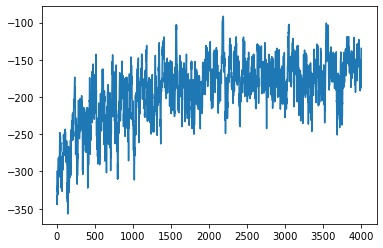

In [5]:
if __name__ == '__main__':
    # env = gym.make(ENV_ID).unwrapped
    env = PendulumSMCEnv()
    # reproducible
    env.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.random.set_seed(RANDOM_SEED)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    action_range = env.action_space.high  # scale action, [-action_range, action_range]

    agent = DDPG(action_dim, state_dim, action_range)

    t0 = time.time()
    if 1:  # train
        all_episode_reward = []
        for episode in range(TRAIN_EPISODES):
            state = env.reset()
            episode_reward = 0
            for step in range(MAX_STEPS):
                if RENDER:
                    env.render()
                # Add exploration noise
                action = agent.get_action(state)
                noise = (np.random.random()-0.5) * 2
                # Target specification
                target = np.array([0.5 * np.sin(0.5*step*env.dt), 0.25 * np.cos(0.5*step*env.dt)])
                target = np.array([0, 0])
                
                state_, reward, done, info, torque, s = env.step(action, target, noise)
                
                agent.store_transition(state, action, reward, state_)

                if agent.pointer > MEMORY_CAPACITY:
                    agent.learn()

                state = state_
                episode_reward += reward
                if done:
                    break

            if episode == 0:
                all_episode_reward.append(episode_reward)
            else:
                all_episode_reward.append(all_episode_reward[-1] * 0.9 + episode_reward * 0.1)
            print(
                'Training  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
                    episode + 1, TRAIN_EPISODES, episode_reward,
                    time.time() - t0
                )
            )
        # agent.save()
        plt.plot(all_episode_reward)
        if not os.path.exists('image'):
            os.makedirs('image')
        plt.savefig(os.path.join('image', '_'.join([ALG_NAME, ENV_ID])))

# load model

In [56]:
# agent = DDPG(action_dim, state_dim, action_range)
# agent.actor = tf.keras.models.load_model('2022-02-02-1-Noise-Sine-SMC-actor.hdf5', compile=False)

Tensor("C_s_input_4:0", shape=(None, 4), dtype=float32)
Tensor("C_s_input_5:0", shape=(None, 4), dtype=float32)


# Testing

In [233]:
env = PendulumSMCEnv()
# sampling time
env.dt=0.005

th_r = []
thdot_r = []

# test
th_list = []
thdot_list = []
action_l = []
torque_l = []
s_l = []
eth_list =[]
ethdot_list=[]
time_list = []

for episode in range(1):
    state = env.reset()
    env.state = np.array([2, 0, 2, 0], dtype=np.float32)
    
    episode_reward = 0
    
    # RL-SMC
    for step in range(4000):
        noise = (np.random.random()-0.5) * 2 * 0.1
        # env.render()
        # Target specification
        target = np.array([2 * np.sin(0.5*step*env.dt), 1 * np.cos(0.5*step*env.dt)])
        # target = np.array([0, 0])
        '''
        if step <= 1000:
            target = np.array([1, 0])
        elif step <= 2000:
            target = np.array([0, 0])
        elif step <= 3000:
            target = np.array([1, 0])
        elif step <= 4000:
            target = np.array([0, 0])
        '''
        
        th_r.append(target[0])
        thdot_r.append(target[1])
        
        state, reward, done, info, torque, s = env.step(agent.get_action(state, greedy=True), target, 0)
        
        th_list.append(state[0])
        thdot_list.append(state[1])
        eth_list.append(state[2])
        ethdot_list.append(state[3])
        action_l.append(agent.get_action(state, greedy=True))
        torque_l.append(float(torque))
        s_l.append(float(s))
        time_list.append(step*env.dt)
        
        episode_reward += reward
        if done:
            break
    '''
    print(
        'Testing  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
            episode + 1, TEST_EPISODES, episode_reward,
            time.time() - t0
        )
    )
    '''

th_list2 = []
thdot_list2 = []
action_l2 = []
torque_l2 = []
s_l2 = []
eth_list2 =[]
ethdot_list2 =[]
for episode in range(1):
    state = env.reset()
    env.state = np.array([2, 0, 2, 0], dtype=np.float32)
    
    episode_reward = 0
    
    # pure SMC
    for step in range(4000):
        # env.render()
        noise = (np.random.random()-0.5) * 2 * 0.1
        
        # Target specification
        target = np.array([2 * np.sin(0.5*step*env.dt), 1 * np.cos(0.5*step*env.dt)])
        # target = np.array([0, 0])
        '''
        if step <= 1000:
            target = np.array([1, 0])
        elif step <= 2000:
            target = np.array([0, 0])
        elif step <= 3000:
            target = np.array([1, 0])
        elif step <= 4000:
            target = np.array([0, 0])
        '''
        
        # state, reward, done, info, torque, s = env.step([100000000000, 6.05052635], target, 0)
        # state, reward, done, info, torque, s = env.step([20, 20], target, noise) # same cost with training
        state, reward, done, info, torque, s = env.step([13.43, 20], target, noise) # cost = sum abs(s)
        
        
        th_list2.append(state[0])
        thdot_list2.append(state[1])
        eth_list2.append(state[2])
        ethdot_list2.append(state[3])
        action_l2.append(agent.get_action(state, greedy=True))
        torque_l2.append(float(torque))
        s_l2.append(float(s))
        
        episode_reward += reward
        if done:
            break
    '''
    print(
        'Testing  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
            episode + 1, TEST_EPISODES, episode_reward,
            time.time() - t0
        )
    
    )
    '''


D:\Anaconda3\envs\tf-cpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Result Plotting

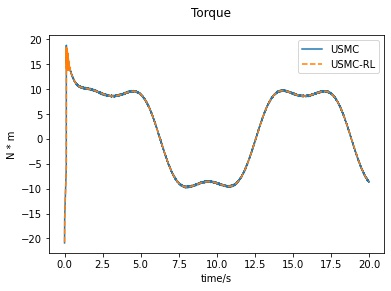

In [234]:
plt.suptitle('Torque')
plt.plot(time_list, torque_l2, label="USMC")
plt.plot(time_list, torque_l, label="USMC-RL", linestyle='dashed')
plt.xlabel('time/s')
plt.ylabel('N * m')
plt.legend()

In [235]:
# sum of output torque
np.sum(abs(np.array(torque_l2))), np.sum(abs(np.array(torque_l)))

(31531.00677462829, 31532.755726146977)

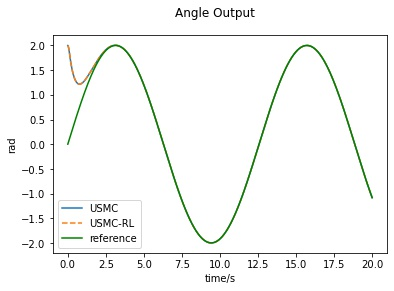

In [236]:
plt.suptitle('Angle Output')
plt.plot(time_list, th_list2, label="USMC")
plt.plot(time_list, th_list, label="USMC-RL", linestyle='dashed')
plt.plot(time_list, th_r, 'g', label="reference")
plt.xlabel('time/s')
plt.ylabel('rad')
plt.legend()

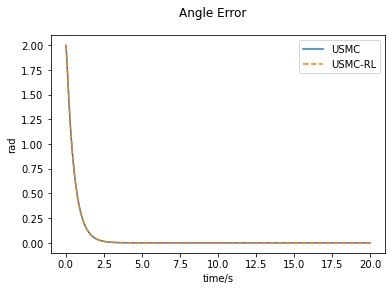

In [237]:
plt.suptitle('Angle Error')
plt.plot(time_list, np.array(th_list2) - np.array(th_r), label="USMC")
plt.plot(time_list, np.array(th_list) - np.array(th_r), label="USMC-RL", linestyle='dashed')
plt.xlabel('time/s')
plt.ylabel('rad')
plt.legend()

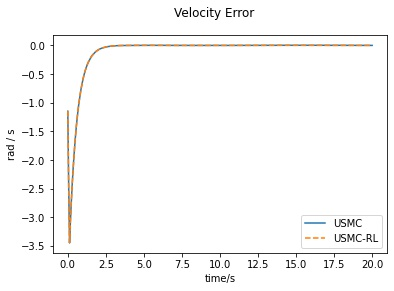

In [238]:
plt.suptitle('Velocity Error')
plt.plot(time_list, np.array(thdot_list2) - np.array(thdot_r), label="USMC")
plt.plot(time_list, np.array(thdot_list) - np.array(thdot_r), label="USMC-RL", linestyle='dashed')
plt.xlabel('time/s')
plt.ylabel('rad / s')
plt.legend()

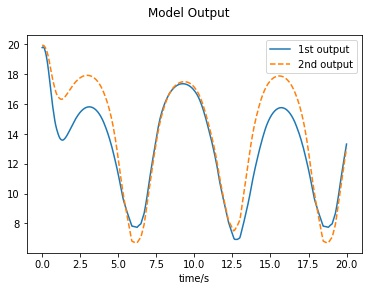

In [239]:
action_l1 = []
action_l2 = []
for i in range(len(action_l)):
    action_l1.append(action_l[i][0].numpy())
    action_l2.append(action_l[i][1].numpy())

plt.suptitle('Model Output')
plt.plot(time_list, action_l1, label="1st output")
plt.plot(time_list, action_l2, label="2nd output", linestyle='dashed')
plt.xlabel('time/s')
plt.legend()

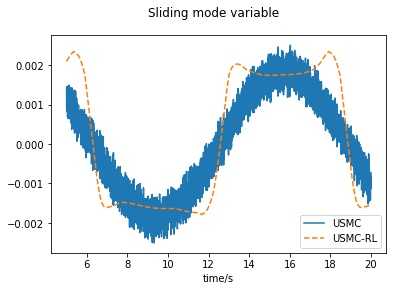

In [242]:
plt.suptitle('Sliding mode variable')
plt.plot(time_list[1000:], s_l2[1000:], label="USMC")
plt.plot(time_list[1000:], s_l[1000:], label="USMC-RL", linestyle='dashed')
plt.xlabel('time/s')
plt.legend()

In [243]:
np.sum(abs(np.array(s_l[:4000]))), np.sum(abs(np.array(s_l2[:4000])))

(39.18208508159712, 37.510301997192634)

# save model

In [35]:
# agent.actor.save('2022-02-02-1-Noise-Sine-SMC-actor.hdf5')
# agent.actor_target.save('2022-02-02-1-Noise-Sine-SMC-actor_target.hdf5')
# agent.critic.save('2022-02-02-1-Noise-Sine-SMC-critic.hdf5')
# agent.critic_target.save('2022-02-02-1-Noise-Sine-SMC-critic_target.hdf5')

# Visualization

In [45]:
value0 = np.zeros((200, 200))
value1 = np.zeros((200, 200))
for i in range(0, 200):
    for j in range(0, 200):
        value = agent.get_action(np.array([0, 0, float((i-100)/50), float((j-100)/50)]), greedy=True).numpy()
        #print(i, j)
        value0[i][j] = value[0]
        value1[i][j] = value[0]
        # ax.scatter3D(i, j, value[i][j], c=value[i][j], cmap='Greens');

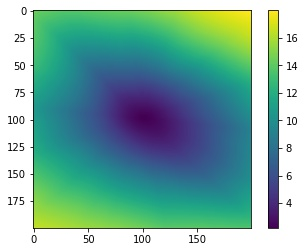

In [46]:
plt.imshow(value0)
plt.colorbar()

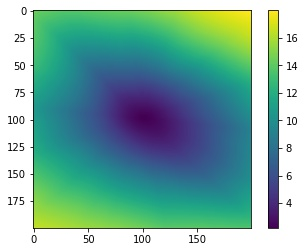

In [47]:
plt.imshow(value1)
plt.colorbar()

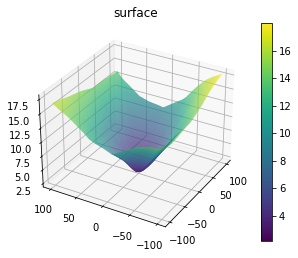

In [48]:
x = np.linspace(-100, 100, 200)
y = np.linspace(-100, 100, 200)
X, Y = np.meshgrid(x, y)
Z = value0
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');
ax.view_init(30, 210)

C = np.linspace(np.min(value0), np.max(value0), 40000).reshape(value1.shape)
scamap = plt.cm.ScalarMappable(cmap='viridis')
fcolors = scamap.to_rgba(C)


#scamap = plt.cm.ScalarMappable(cmap='viridis')

# fcolors = scamap.to_rgba(C)
# ax.plot_surface(X, Y, Z, facecolors=fcolors, cmap='viridis')
fig.colorbar(scamap)

plt.show()

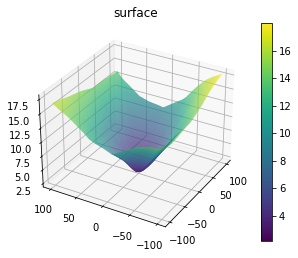

In [49]:
x = np.linspace(-100, 100, 200)
y = np.linspace(-100, 100, 200)
X, Y = np.meshgrid(x, y)
Z = value1
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');
ax.view_init(30, 210)

C = np.linspace(np.min(value1), np.max(value1), 40000).reshape(value1.shape)
scamap = plt.cm.ScalarMappable(cmap='viridis')
fcolors = scamap.to_rgba(C)


#scamap = plt.cm.ScalarMappable(cmap='viridis')

# fcolors = scamap.to_rgba(C)
# ax.plot_surface(X, Y, Z, facecolors=fcolors, cmap='viridis')
fig.colorbar(scamap)

plt.show()

# combining U-model

In [7]:
import sympy
import copy
t3, s3 = sympy.symbols('t, s')

env = PendulumSMCEnv()
env.dt=0.005

th_r = []
thdot_r = []

# test
# agent.load()
th_list = []
thdot_list = []
action_l = []
torque_l = []
s_l = []
eth_list =[]
ethdot_list=[]

for episode in range(1):
    # state initialisation
    state = env.reset()
    env.state = np.array([2, 1, 2, 0], dtype=np.float32)
    
    episode_reward = 0
    
    '''
        
    ############# Constant target angle
    target = np.array([1, 0])
    target0 = target[0]
    target1 = target[1]

    target0 = target0 / s3
    target1 = target1 / s3

    transfer = 25 / (s3**2 + 10 * s3 +25)
    target0 = sympy.Mul(target0, transfer)
    target1 = sympy.Mul(target1, transfer)
    itransfer0 = sympy.inverse_laplace_transform(target0, s3, t3)
    itransfer1 = sympy.inverse_laplace_transform(target1, s3, t3)
    #############################
    '''
    
    # Target specification
        
    ############# sine target angle
    target = np.array([2 * np.sin(0.5*step*env.dt), 1 * np.cos(0.5*step*env.dt)])
    target0 = 2 * 0.5 / (s3**2 + 0.25)
    target1 = s3 / (s3**2 + 0.25)
    itransfer0 = sympy.inverse_laplace_transform(2500/(100*s3**4+1000*s3**3+2525*s3**2+250*s3+625), s3, t3).evalf().simplify()
    itransfer1 = sympy.inverse_laplace_transform(2500*s3/(100*s3**4+1000*s3**3+2525*s3**2+250*s3+625), s3, t3).evalf().simplify()
        
        
    for step in range(10000):
        
        if step%100 == 0:
            print(step)
            
        noise = (np.random.random()-0.5) * 2 * 0.01

        
        
        #################################
        
        
        # get timie-domain value
        value0 = itransfer0.evalf(subs ={'t':env.dt*(step+1)})
        value1 = itransfer1.evalf(subs ={'t':env.dt*(step+1)})
        target = np.array([value0, value1])
    
    
    
        #target = np.array([0, 0])
        th_r.append(2 * np.sin(0.5*step*env.dt))
        thdot_r.append(1 * np.cos(0.5*step*env.dt))
        
        state, reward, done, info, torque, s = env.step(agent.get_action(state, greedy=True), target, 0)
        
        th_list.append(state[0])
        thdot_list.append(state[1])
        eth_list.append(state[2])
        ethdot_list.append(state[3])
        action_l.append(agent.get_action(state, greedy=True))
        torque_l.append(float(torque))
        s_l.append(float(s))
        
        episode_reward += reward
        if done:
            break
    print(
        'Testing  | Episode: {}/{}  | Episode Reward: {:.4f}  | Running Time: {:.4f}'.format(
            episode + 1, TEST_EPISODES, episode_reward,
            time.time() - t0
        )
    )

D:\Anaconda3\envs\tf-cpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
Testing  | Episode: 1/10  | Episode Reward: -17040.1960  | Running Time: 246.9011
